In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [8]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
df = pd.read_csv("/content/data/daily_min_temp.csv", parse_dates=["Date"], index_col = "Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [13]:
df = df.resample("W").mean()

<Axes: xlabel='Date'>

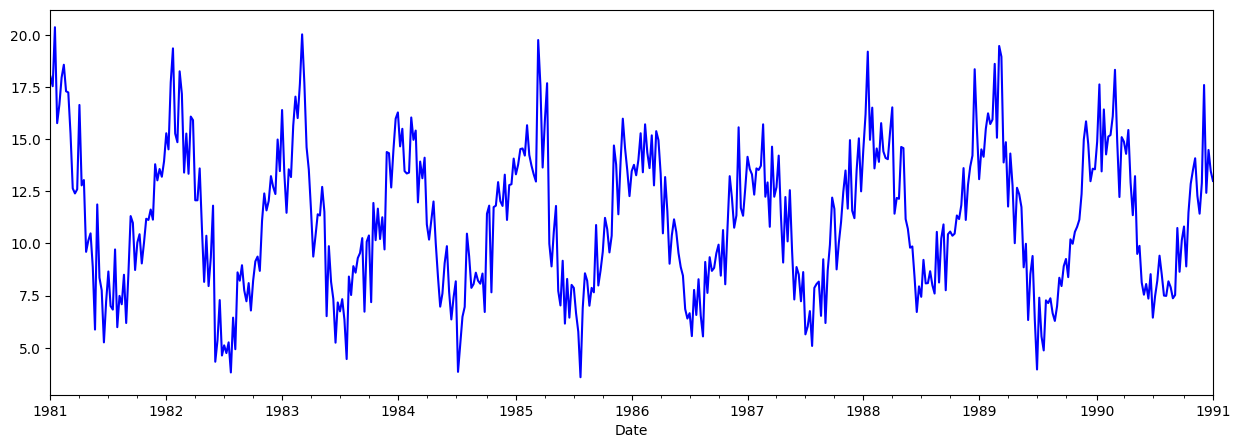

In [14]:
df.Temp.plot(figsize=(15, 5), color='b')

<h2> Dataset splitting

In [15]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

<h2> Dataset & Dataloader

In [16]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [17]:
seq_len = 6
bs = 16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (69, 6, 1)
Note: last 3 data excluded

(N, S, F): (17, 6, 1)
Note: last 2 data excluded



<h2> Arsitektur & Config

In [18]:
from jcopdl.layers import linear_block

In [34]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) # NFS -> N/Batch First maka True
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
         # hidden bisa tidak perlu dikeluarkan, tapi nanti di loop function tidak usah di define

In [21]:
train_set.n_feature

1

In [35]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers" : 2,
    "dropout" : 0,
    "seq_len": train_set.n_seq
})

<h2> Training Preparation -> MCOC

In [36]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [37]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        #output, hidden -> hidden bisa dibuang jika tidak digunakan
        output, hidden = model(feature, None) # inputnya ada 2, hiddennya None, maka hidden nya otomatis 0
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 119.9517 | Test_cost  = 111.3698 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 96.7891 | Test_cost  = 91.7607 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 79.4798 | Test_cost  = 76.6019 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 66.3861 | Test_cost  = 65.7511 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 57.1721 | Test_cost  = 58.1878 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 50.6174 | Test_cost  = 52.4436 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 45.4745 | Test_cost  = 47.6395 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 41.1138 | Test_cost  = 43.4405 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 37.2937 | Test_cost  = 39.7054 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 33.9032 | Test_cost  = 36.3617 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 30.8830 | Test_cost  = 33.3700 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 28.1984 | Test_cost  = 30.7036 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 25.8227 | Test_cost  = 28.3372 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 23.7297 | Test_cost  = 26.2449 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 21.8937 | Test_cost  = 24.4016 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 20.2895 | Test_cost  = 22.7831 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 18.8937 | Test_cost  = 21.3670 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 17.6843 | Test_cost  = 20.1322 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 16.6411 | Test_cost  = 19.0593 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 15.7452 | Test_cost  = 18.1302 | 


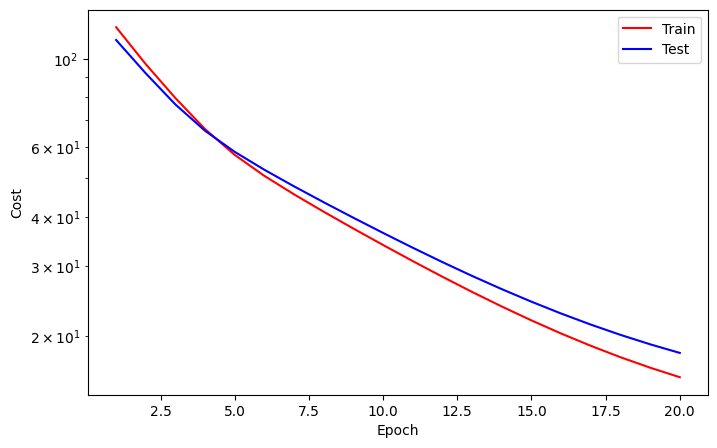

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 14.9793 | Test_cost  = 17.3284 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 14.3273 | Test_cost  = 16.6385 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 13.7749 | Test_cost  = 16.0468 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 13.3089 | Test_cost  = 15.5407 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 12.9174 | Test_cost  = 15.1089 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 12.5898 | Test_cost  = 14.7414 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 12.3170 | Test_cost  = 14.4294 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 12.0905 | Test_cost  = 14.1648 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 11.9032 | Test_cost  = 13.9409 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 11.7488 | Test_cost  = 13.7516 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 11.6220 | Test_cost  = 13.5917 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 11.5181 | Test_cost  = 13.4567 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 11.4332 | Test_cost  = 13.3427 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 11.3639 | Test_cost  = 13.2465 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 11.3074 | Test_cost  = 13.1652 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 11.2613 | Test_cost  = 13.0964 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 11.2238 | Test_cost  = 13.0381 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 11.1932 | Test_cost  = 12.9886 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 11.1682 | Test_cost  = 12.9466 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 11.1476 | Test_cost  = 12.9107 | 


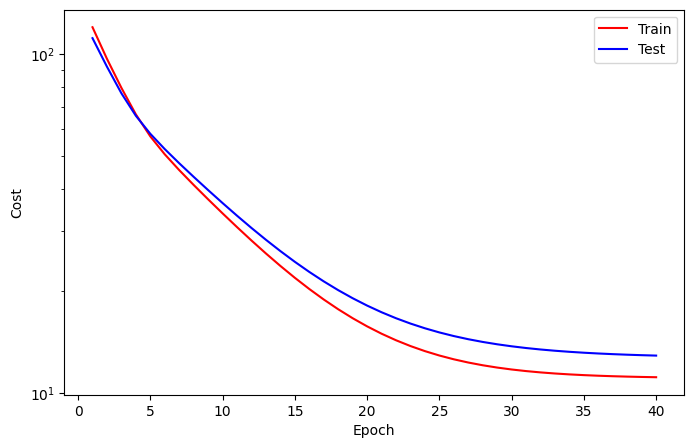

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 11.1307 | Test_cost  = 12.8801 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 11.1167 | Test_cost  = 12.8538 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 11.1050 | Test_cost  = 12.8311 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 11.0952 | Test_cost  = 12.8115 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 11.0869 | Test_cost  = 12.7945 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 11.0797 | Test_cost  = 12.7796 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 11.0736 | Test_cost  = 12.7666 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 11.0681 | Test_cost  = 12.7550 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 11.0633 | Test_cost  = 12.7447 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 11.0590 | Test_cost  = 12.7354 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 11.0550 | Test_cost  = 12.7270 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 11.0513 | Test_cost  = 12.7193 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 11.0479 | Test_cost  = 12.7122 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 11.0447 | Test_cost  = 12.7056 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 11.0415 | Test_cost  = 12.6993 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 11.0385 | Test_cost  = 12.6933 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 11.0356 | Test_cost  = 12.6875 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11.0327 | Test_cost  = 12.6818 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11.0298 | Test_cost  = 12.6763 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 11.0269 | Test_cost  = 12.6708 | 


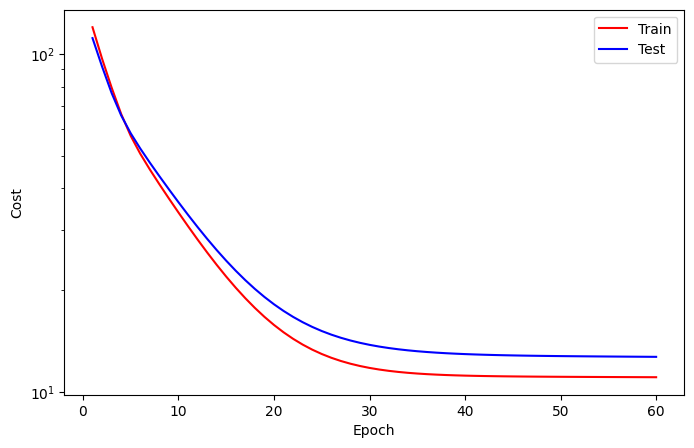

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 11.0241 | Test_cost  = 12.6654 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 11.0211 | Test_cost  = 12.6599 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 11.0182 | Test_cost  = 12.6543 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 11.0152 | Test_cost  = 12.6487 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 11.0121 | Test_cost  = 12.6430 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 11.0090 | Test_cost  = 12.6372 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 11.0058 | Test_cost  = 12.6313 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 11.0024 | Test_cost  = 12.6251 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 10.9990 | Test_cost  = 12.6188 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 10.9955 | Test_cost  = 12.6123 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 10.9918 | Test_cost  = 12.6056 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 10.9879 | Test_cost  = 12.5986 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 10.9838 | Test_cost  = 12.5912 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 10.9795 | Test_cost  = 12.5835 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 10.9748 | Test_cost  = 12.5753 | 

Epoch    79
Train_cost  = 10.9469 | Test_cost  = 12.5303 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 10.9333 | Test_cost  = 12.5115 | 


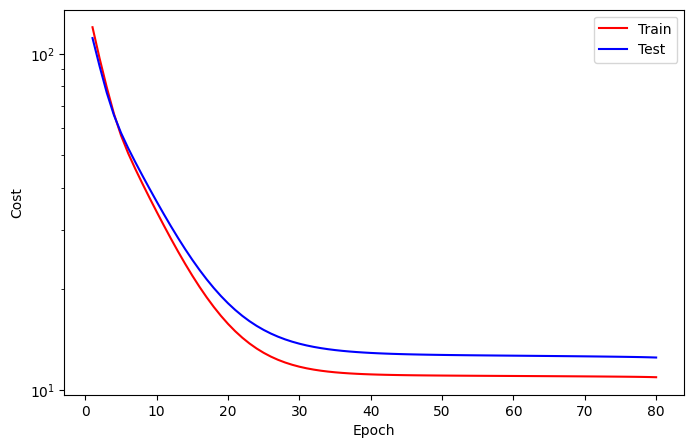

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 10.9111 | Test_cost  = 12.4801 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 10.8594 | Test_cost  = 12.4540 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 10.8042 | Test_cost  = 12.4622 | 
==> EarlyStop patience =  1 | Best test_cost: 12.4540


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 10.7460 | Test_cost  = 12.3272 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 10.5952 | Test_cost  = 12.0789 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 10.3014 | Test_cost  = 11.7101 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 9.7661 | Test_cost  = 11.1007 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 9.0325 | Test_cost  = 10.4346 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 8.6799 | Test_cost  = 10.0852 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 8.4623 | Test_cost  = 9.7702 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 8.1170 | Test_cost  = 9.4522 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 4.2607 | Test_cost  = 4.4046 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 4.2069 | Test_cost  = 4.3285 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 4.1577 | Test_cost  = 4.2576 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 4.1131 | Test_cost  = 4.1920 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 4.0719 | Test_cost  = 4.1303 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 4.0345 | Test_cost  = 4.0728 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 4.0000 | Test_cost  = 4.0190 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 3.9683 | Test_cost  = 3.9687 | 


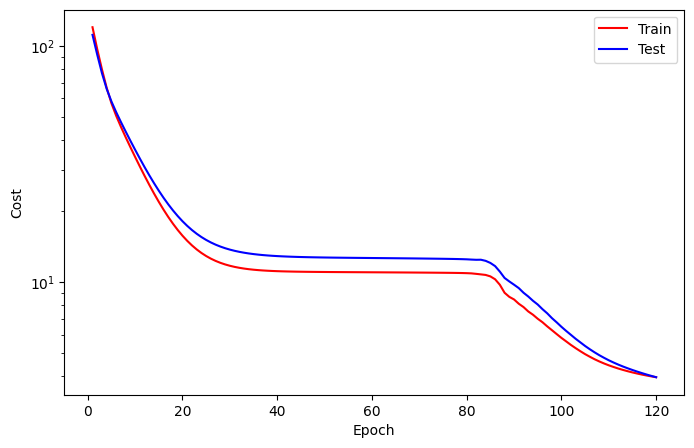

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 3.9391 | Test_cost  = 3.9220 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 3.9119 | Test_cost  = 3.8783 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 3.8867 | Test_cost  = 3.8377 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 3.8631 | Test_cost  = 3.7996 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 3.8410 | Test_cost  = 3.7639 | 


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 3.5772 | Test_cost  = 3.3722 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 3.5675 | Test_cost  = 3.3610 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 3.5581 | Test_cost  = 3.3503 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 3.5489 | Test_cost  = 3.3401 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 3.5398 | Test_cost  = 3.3303 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 3.5309 | Test_cost  = 3.3209 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 3.5222 | Test_cost  = 3.3118 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 3.5136 | Test_cost  = 3.3030 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 3.5051 | Test_cost  = 3.2945 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 3.4968 | Test_cost  = 3.2863 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 3.4886 | Test_cost  = 3.2783 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 3.4805 | Test_cost  = 3.2705 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]

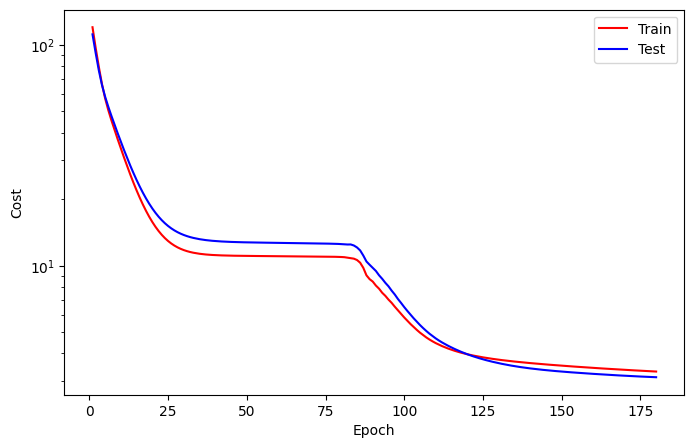

Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 3.3075 | Test_cost  = 3.1184 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 3.3020 | Test_cost  = 3.1145 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 3.2967 | Test_cost  = 3.1109 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 3.2915 | Test_cost  = 3.1075 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 3.2864 | Test_cost  = 3.1042 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 3.2814 | Test_cost  = 3.1013 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 3.2765 | Test_cost  = 3.0985 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 3.2718 | Test_cost  = 3.0960 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 3.2671 | Test_cost  = 3.0937 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 3.2626 | Test_cost  = 3.0916 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 3.2581 | Test_cost  = 3.0897 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 3.2538 | Test_cost  = 3.0880 | 


Train:   0%|          | 0/5 [00:00<?, ?it/s]

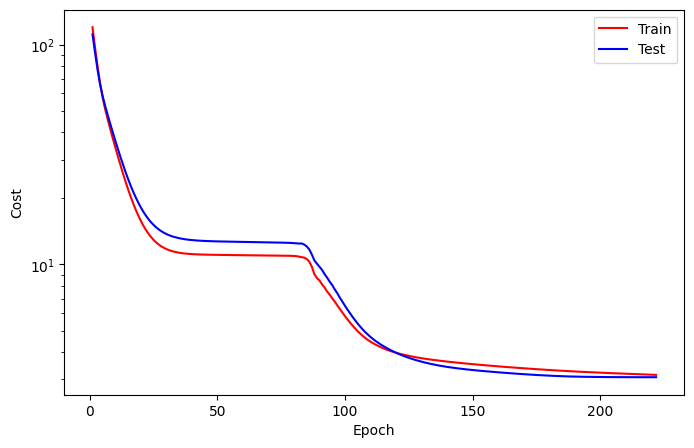

In [38]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> Forecast

In [51]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [53]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1) # forecasting jadi per 1 data, input 1 pred 1
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

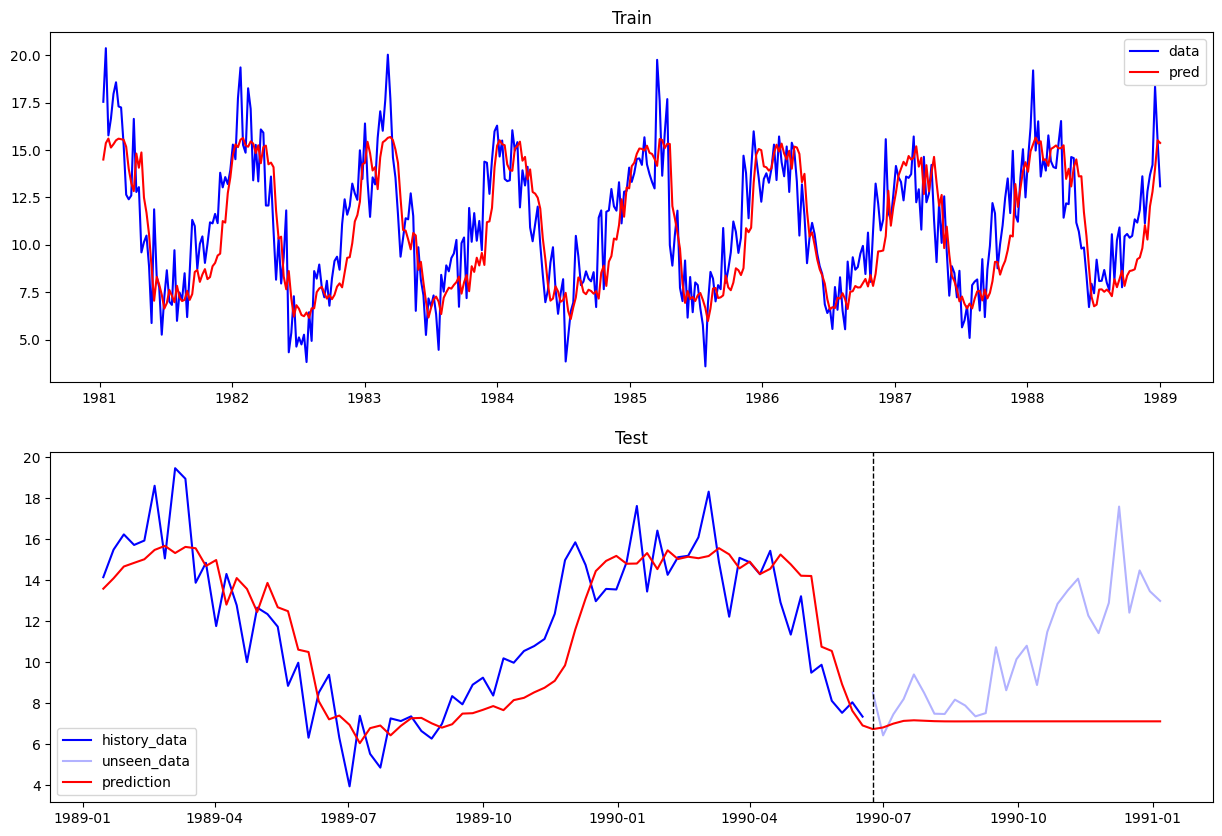

In [54]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")